## Credit Scoring
### Goal:
Build a scoring model for the bank's secondary clients, which would predict the probability of a client's default.
### Tasks:
- Handle missing data (NaN)
- Find outliers 
- Make preprocessing of various data
- Encode and get new signs (Feature Engineering)
- Include new features in the analysis of key variables, assess their importance and contribution to the model 
- Get a new value of ROC AUC for a new model and try to improve its results based on the selection of the regularization parameter 

### Field descriptions 
- client_id - client identifier
- education - level of education
- sex - borrower's gender
- age - borrower's age
- car - flag of the presence of a car
- car_type - flag of a foreign car
- decline_app_cnt - number of rejected past applications
- good_work - flag of having "good" work
- bki_request_cnt - number of requests to the bki
- home_address - home address categorizer
- work_address - work address categorizer
- income - borrower's income
- foreign_passport - availability of a foreign passport
- sna - communication between the borrower and the bank's clients
- first_time - how old the information about the borrower was
- score_bki - scoring score according to data from the BKI
- region_rating - region rating
- app_date - date of application submission
- default - credit default flag

## Import

In [47]:
#importing libraries and modules 
import pandas as pd # for reading files, working DataFrames and Series, reading time 
import numpy as np # for combine arrays, find outliers, work with arrays
import matplotlib.pyplot as plt # for figures
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler # data transformation
import seaborn as sns # for creating heatmap
from sklearn.feature_selection import f_classif, mutual_info_classif # to sort features by importance
from sklearn.metrics import roc_auc_score, roc_curve # tools for assessing model accuracy
from sklearn.linear_model import LogisticRegression # for creating logistic regression model
from sklearn.model_selection import train_test_split, GridSearchCV # to split data and iterate over regularization parameters 
label_encoder = LabelEncoder() # binary data processing function

def cat(column, n = 0, b = 2): # function for processing categorical data
    if n == 0: # condition for transforming categorical data 
        data_n = data[column].nunique() # number of unique values
        data_dict = {data[column].unique()[i]:i for i in range(data_n)} # creating dictionary
        data[column].replace(data_dict, inplace = True) # replacing values with numbers
    else: # if don't need to replace
        print(data[column].hist(bins = b)) # print histogram 
    
    print(data[column].nunique()) # print number of unique number
    display(data.head()) # display data

def bin(column): # function for processing binary data
    plt.rcParams['figure.figsize'] = (5,5) # size area
    data[column].hist(bins=2) # histogram with two columns
    data[column] = label_encoder.fit_transform(data[column]) # processing in binary data 
    print(dict(enumerate(label_encoder.classes_))) # print dictionary with deciphering meanings
    data.head()

def outliers_iqr(ys): # function for filling outliers
    quartile_1, quartile_2 = np.percentile(ys, [25, 75]) # save quartiles
    iqr = quartile_2 - quartile_1 # save interquartile range 
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_2 + (iqr * 1.5)
    out = []
    for i in ys: # creating new array without outliers
        if i > upper_bound:
            out.append(upper_bound)
        elif i < lower_bound:
            out.append(lower_bound)
        else:
            out.append(i)
    return out

def boxhist(col, n = 0, b = 2): # function for display box plot or histogram 
    if n == 0:
        data.boxplot(column = col) # display boxplot
    else:
        data[col] = outliers_iqr(data[col]) # delete outliers
        data[col].hist(bins = b) # display histogram
        print(data[col].value_counts()) 
    print(data[col].nunique())

def undsamp(X, y): # function for undersampling 
    X = pd.DataFrame([X[i] for i in range(len(X))],
           columns = np.arange(X.shape[1])) # processing data in DataFrames format
    X['def'] = y
    mincl = X['def'].value_counts()[1] # number of objects of the minimum class
    X = pd.concat([X[X['def'] == 0][:mincl], X[X['def'] == 1]]) # concatenating the one and zero classes
    return X.drop(['def'], axis = 1).values, X['def'].values # return for x and y

def logreg(X, y, C = 1.0, p = 'l2', n = 0): # function for testing logistic regression model 
    myModel = LogisticRegression(C = C, penalty = p) # denote that our model is logistic regression
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42) # dividing the sample into training and test 
  
    myModel.fit(X_train,y_train) # train the model on training data
    probs_tr = myModel.predict_proba(X_train)[:,1] # checking the model on the training set
    probs_te = myModel.predict_proba(X_test)[:,1] # checking the model on the testing set

    fpr, tpr, threshold = roc_curve(y_test, probs_te) # roc curve plot values
    roc_auc_tr = roc_auc_score(y_train, probs_tr) # score of ROC AUC metric for train data
    roc_auc_te = roc_auc_score(y_test, probs_te) # score of ROC AUC metric for test data 
    
    print('Logistic Regression ROC AUC = %0.3f' % roc_auc_te) # print ROC AUC metric value on the testing set
    print(f'ROC AUC train: {roc_auc_tr:.3f}') # print ROC AUC metric value on the training set
    print('change: %0.3f' % (roc_auc_te - roc_auc_tr)) # difference in metric scores for training and test samples
 
    if(n == 1): # if need to plot a curve
        X_train_und, y_train_und = undsamp(X_train, y_train) # reduction of the majority class
        myModel.fit(X_train_und,y_train_und) # train the model on balanced data 
        probs = myModel.predict_proba(X_test)[:,1] # model prediction on test data
        roc_auc = roc_auc_score(y_test, probs) # score of ROC AUC metric for test data 
        print(f'ROC AUC undersampling: {roc_auc:.3f}') # print ROC AUC metric value
        print(f'1 in train: {sum(y_train_und)/len(y_train_und):.3f}','\n', \
              f'1 in test: {sum(y_test)/len(y_test):.3f}') # testing class relations in balanced and primary elections 
        
        plt.plot([0, 1], label='Baseline', linestyle='--') # plot baseline
        plt.plot(fpr, tpr, label = 'Regression') # transfer curve point coordinates 
        plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc_te) # title with ROC AUC score
        plt.ylabel('True Positive Rate') # signature y coordinates 
        plt.xlabel('False Positive Rate') # signature x coordinates
        plt.legend(loc = 'lower right') # legend location 
        plt.show() # graph display

def prepro(p_data): # the function prepares data for the model
    num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'region_rating', 'income', 'sna', 'first_time'] # numeric columns 
    bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport'] # binary columns
    cat_cols = ['education', 'home_address', 'work_address'] # categorical columns 
    
    date_max = p_data.app_date.max() # latest date
    X = pd.DataFrame({'days':p_data.app_date.apply(lambda x:(date_max-x).days)}) # replacing dates with the number of days from the maximum date 
    X = np.hstack([X, p_data.iloc[:, 4:5] ** 3, np.sqrt(p_data.iloc[:, 14:15])]) # concatenate columns, cube a column with age, root an income column
    X = StandardScaler().fit_transform(X) # standardize data
    X_cat = OneHotEncoder(sparse = False).fit_transform(p_data[cat_cols].values) # breaking categorical data into binary columns
    X_num = StandardScaler().fit_transform(p_data[num_cols].values) # standardize numerical data
    return np.hstack([X, X_num, p_data[bin_cols].values, X_cat]) # concatenate columns

## Data

In [48]:
# read csv files with dataset 
train = pd.read_csv('/kaggle/input/b-scoring/train.csv')
test = pd.read_csv('/kaggle/input/b-scoring/test.csv')

train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [49]:
# data for testing
test.info()
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [50]:
# for correct processing of features, combine the train and test into one dataset
train['sample'] = 1 # mark where we have train
test['sample'] = 0 # mark where we have the test
test['default'] = 0 # in the test we do not have the default value, we must predict it, so for now we just fill it with zeros
data = test.append(train, sort = False).reset_index(drop = True) # unite
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

## Cleaning and Prepping Data

### 1. App_date

<AxesSubplot:ylabel='date'>

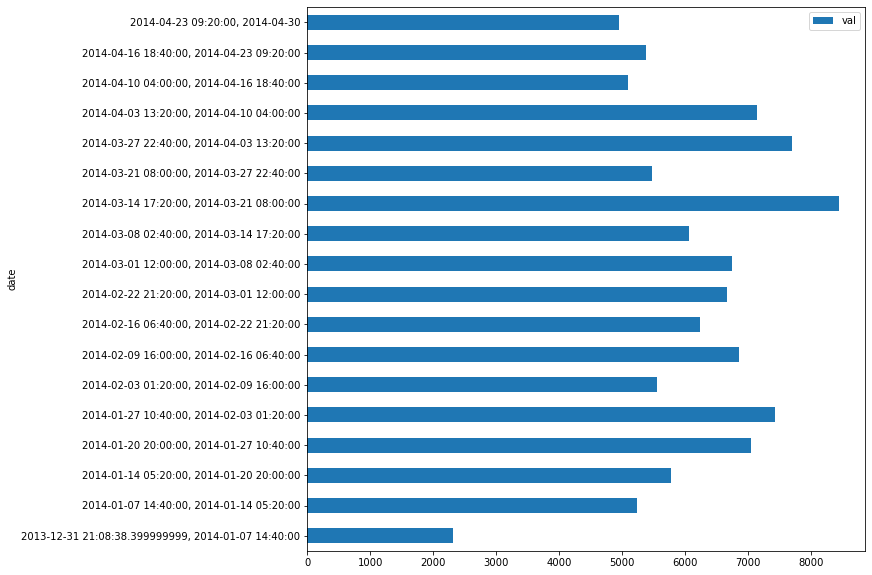

In [51]:
data.app_date = pd.to_datetime(data.app_date) # convert to date
plt.rcParams['figure.figsize'] = (10,10) # plot area dimensions
date_intrv = data['app_date'].value_counts(bins = 18) # grouping dates by week 
date = pd.DataFrame({'val':date_intrv.values, 'date':[str(x)[1:-1] for x in date_intrv.index]}).sort_values('date') # convert date range to string and sort
date.plot(y = 'val', x = 'date', kind = 'barh') # display grouping dates 

Applications are submitted evenly every day for four months.

### 2. Education

0.0043


<AxesSubplot:>

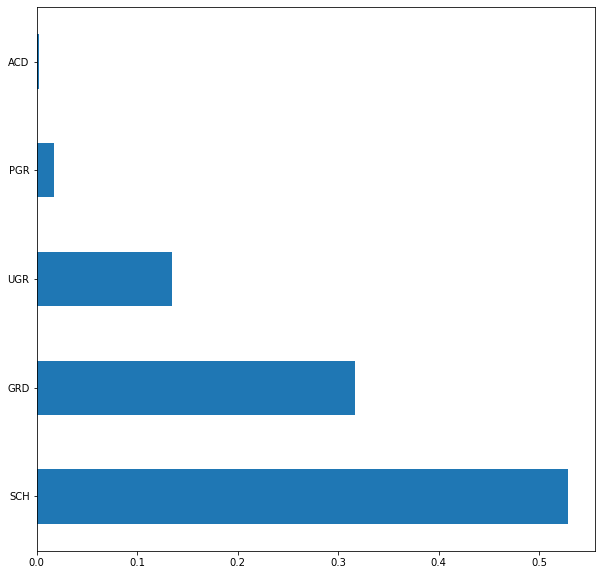

In [52]:
print(f'{data.education.isna().value_counts(normalize = True)[1]:.4f}') # percentage of omissions 
data.education.value_counts(normalize = True).plot(kind = 'barh') # plot level of education

There are few gaps, half is filled with SCH, we can fill in the gaps with this value. 

In [53]:
data = data.fillna('SCH') # fill in the gaps with the prevailing level
cat('education') # replacing levels with numbers, print number unique values

5


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,2014-03-22,0,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,0
1,17527,2014-01-24,1,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,0
2,75683,2014-03-23,2,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,0
3,26883,2014-02-03,1,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,0
4,28862,2014-02-04,0,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,0


### 3. Sex

{0: 'F', 1: 'M'}


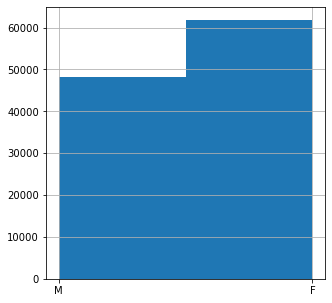

In [54]:
bin('sex') # plot binary values

More women among clients. 

### 4. Age

52


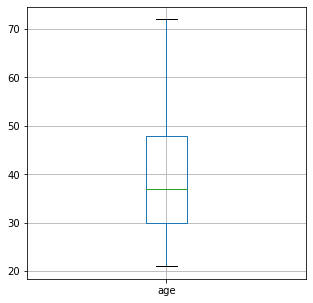

In [55]:
boxhist('age') # display boxplot, print number unique values 

31    4084
30    4035
28    4035
27    3964
29    3940
26    3780
32    3773
34    3548
33    3499
35    3386
25    3292
36    3228
37    3185
39    3095
38    3070
40    2950
42    2857
41    2804
24    2780
43    2672
44    2536
23    2295
45    2235
50    2104
46    2102
48    2084
47    2074
52    2065
51    2015
53    1980
49    1964
54    1911
55    1837
56    1641
57    1578
22    1415
58    1373
59    1340
21    1262
60    1236
61     975
62     885
63     720
64     663
65     618
66     442
67     382
68     261
69     110
70      60
71       6
72       2
Name: age, dtype: int64
52


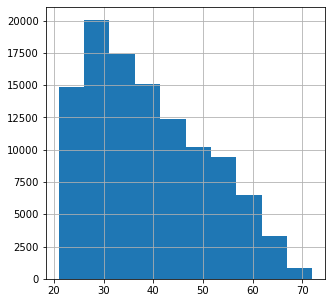

In [56]:
boxhist('age', 1, 10) # plot histogram, print unique values

Most borrowers are between the ages of 20 and 40, the active part of the population. 

### 5. Car

{0: 'N', 1: 'Y'}


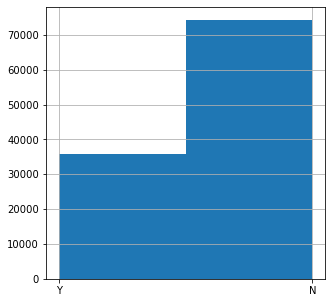

In [57]:
bin('car') # plot binary values

Most don't have cars. 

### 6. Car_type

{0: 'N', 1: 'Y'}


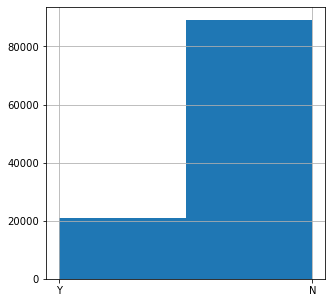

In [58]:
bin('car_type') # plot binary values

Most do not have foreign cars. 

### 7. Decline_app_cnt

In [59]:
print(data.decline_app_cnt.nunique()) # print unique number of rejected past applications 
data.decline_app_cnt.value_counts() # number of values of each type

24


0     91471
1     12500
2      3622
3      1365
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
16        3
15        1
19        1
20        1
21        1
22        1
24        1
30        1
33        1
Name: decline_app_cnt, dtype: int64

0    91471
1    12500
2     3622
3     1365
4     1190
Name: decline_app_cnt, dtype: int64
0.0


<AxesSubplot:>

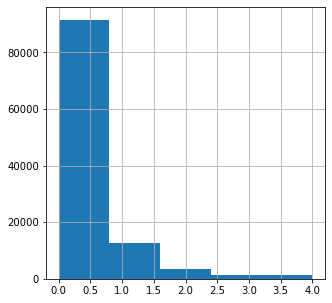

In [60]:
# group the values from 4 to 33
data_dict = {i:i for i in range(4)} # create dictionary for fist 4 values
for i in range(4, 34): # set all other values to 'four'
    data_dict.setdefault(i, 4)
     
data.decline_app_cnt = data.decline_app_cnt.replace(data_dict) # replace values with dictionary values
print(data.decline_app_cnt.value_counts()) # print number of values of each type

# check if there is an outlier
quartile_1, quartile_2 = np.percentile(data.decline_app_cnt, [25, 75]) # save quartiles
iqr = quartile_2 - quartile_1 # save interquartile range
print(quartile_2 + (iqr * 1.5)) # print upper bound

data.decline_app_cnt.hist(bins=5) # display histogram 

There are few failures. 

### 8. Good_work

0    91917
1    18231
Name: good_work, dtype: int64


<AxesSubplot:>

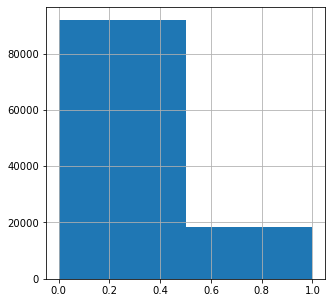

In [61]:
print(data.good_work.value_counts()) # print good work values 
data.good_work.hist(bins = 2) # display histogram 

Most don't have a good job. 

### 9. Score_bki

102618


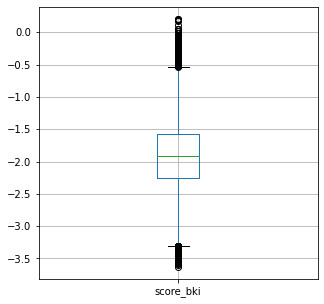

In [62]:
boxhist('score_bki') # display boxplot, print number unique values 

-1.775263    517
-2.104211    454
-0.529070    436
-2.225004    424
-2.169664    375
            ... 
-1.845090      1
-2.525894      1
-1.256585      1
-1.570582      1
-2.296371      1
Name: score_bki, Length: 102126, dtype: int64
102126


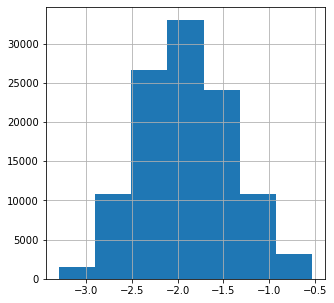

In [63]:
boxhist('score_bki', 1, 7) # print value counts, number unique values, print histogram 

Most have average points, distribution is normal. 

### 10. Bki_request_cnt

40


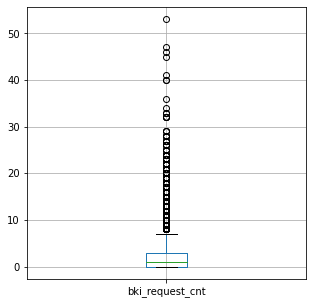

In [64]:
boxhist('bki_request_cnt') # display boxplot, print number unique values  

0.0    28908
1.0    27295
2.0    20481
3.0    13670
4.0     8406
5.0     4960
7.5     2636
6.0     2500
7.0     1292
Name: bki_request_cnt, dtype: int64
9


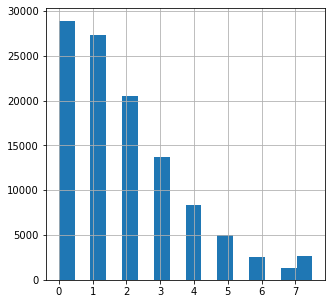

In [65]:
boxhist('bki_request_cnt', 1, 16) # print value counts, number unique values, print histogram 

The number of requests to bki decreases. Lots of outliers. 

### 11. Region_rating

7


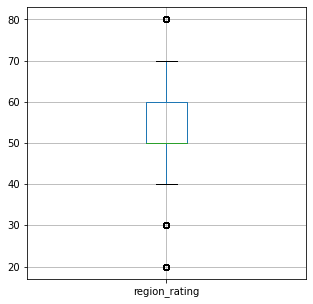

In [66]:
boxhist('region_rating') # display boxplot, print number unique values

50.0    40981
60.0    23999
40.0    17947
75.0    17170
70.0     9304
35.0      747
Name: region_rating, dtype: int64
6


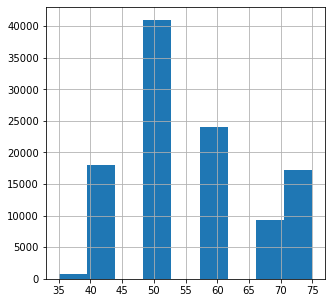

In [67]:
boxhist('region_rating', 1, 9) # print value counts, number unique values, print histogram  

Most from the region with an average rating. The distribution is normal.

### 12. Home_address

3


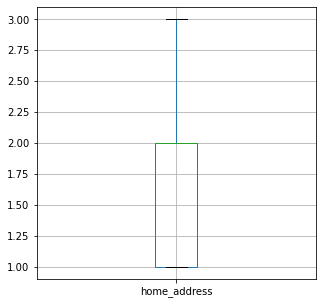

In [68]:
boxhist('home_address') # display boxplot, print number unique values 

AxesSubplot(0.125,0.125;0.775x0.755)
3


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,2014-03-22,0,1,29,1,1,0,0,-2.271884,3.0,50.0,1,2,50000,1,4,N,0,0
1,17527,2014-01-24,1,0,39,0,0,4,0,-1.504999,2.0,50.0,1,2,5000,4,3,N,0,0
2,75683,2014-03-23,2,1,50,1,1,0,0,-1.691339,1.0,50.0,1,2,30000,1,3,Y,0,0
3,26883,2014-02-03,1,1,56,0,0,0,0,-2.374182,1.0,40.0,1,2,17000,1,3,N,0,0
4,28862,2014-02-04,0,0,38,0,0,0,0,-2.487502,0.0,75.0,2,3,120000,1,3,N,0,0


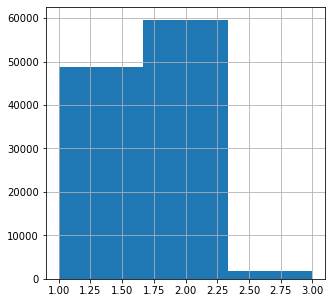

In [69]:
cat('home_address', 1, 3) # print number unique values, plot histogram 

Most have addresses from the first two categories. 

### 13. Work_address

3


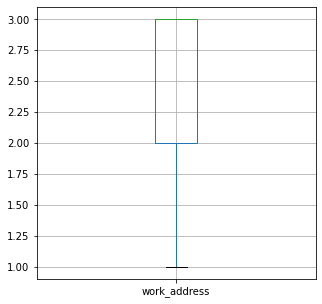

In [70]:
boxhist('work_address') # display boxplot, print number unique values

AxesSubplot(0.125,0.125;0.775x0.755)
3


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,2014-03-22,0,1,29,1,1,0,0,-2.271884,3.0,50.0,1,2,50000,1,4,N,0,0
1,17527,2014-01-24,1,0,39,0,0,4,0,-1.504999,2.0,50.0,1,2,5000,4,3,N,0,0
2,75683,2014-03-23,2,1,50,1,1,0,0,-1.691339,1.0,50.0,1,2,30000,1,3,Y,0,0
3,26883,2014-02-03,1,1,56,0,0,0,0,-2.374182,1.0,40.0,1,2,17000,1,3,N,0,0
4,28862,2014-02-04,0,0,38,0,0,0,0,-2.487502,0.0,75.0,2,3,120000,1,3,N,0,0


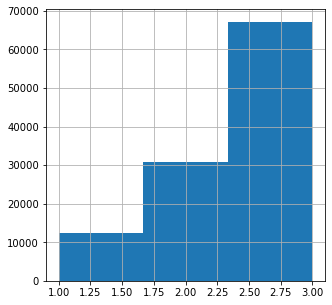

In [71]:
cat('work_address', 1, 3) # print number unique values, plot histogram 

Most have a third category of work address. 

### 14. Income

1207


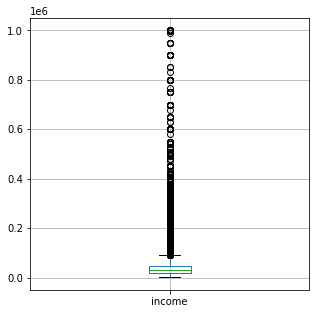

In [72]:
boxhist('income') # display boxplot, print number unique values

30000.0    10437
25000.0     9090
20000.0     8174
90000.0     7749
40000.0     7383
           ...  
17241.0        1
25964.0        1
6225.0         1
12220.0        1
10656.0        1
Name: income, Length: 982, dtype: int64
982


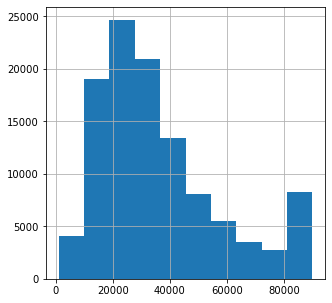

In [73]:
boxhist('income', 1, 10) # print value counts, number unique values, print histogram 

Most have a slightly less than average income. Lots of outliers. 

### 15. Sna

4


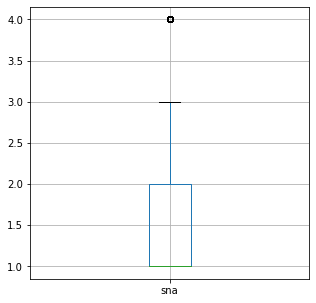

In [74]:
boxhist('sna') # display boxplot, print number unique values

1.0    70681
3.5    17481
2.0    15832
3.0     6154
Name: sna, dtype: int64
4


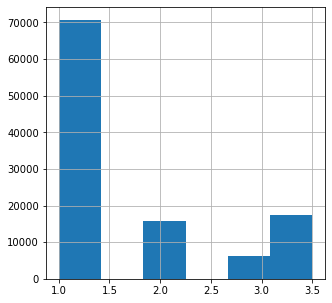

In [75]:
boxhist('sna', 1, 6) # print value counts, number unique values, print histogram 

There are few strong links between borrowers and bank customers. There are outliers. 

### 16. First_time 

4


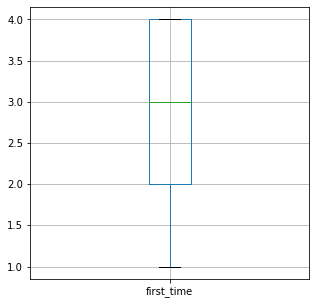

In [76]:
boxhist('first_time') # display boxplot, print number unique values

3    46588
4    28017
1    18296
2    17247
Name: first_time, dtype: int64
4


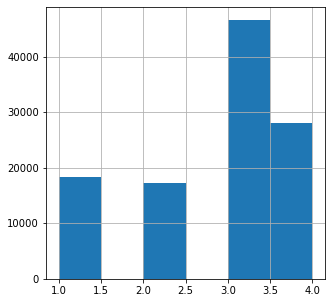

In [77]:
boxhist('first_time', 1, 6) # print value counts, number unique values, print histogram 

Lots of long-standing information about the borrower. 

### 17. Foreign_passport

{0: 'N', 1: 'Y'}


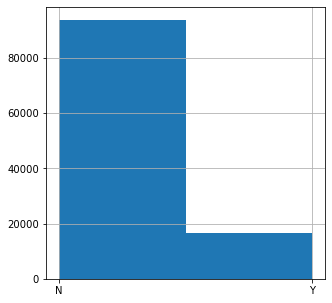

In [78]:
bin('foreign_passport') # plot binary values

Most do not have a passport. 

## EDA

<AxesSubplot:>

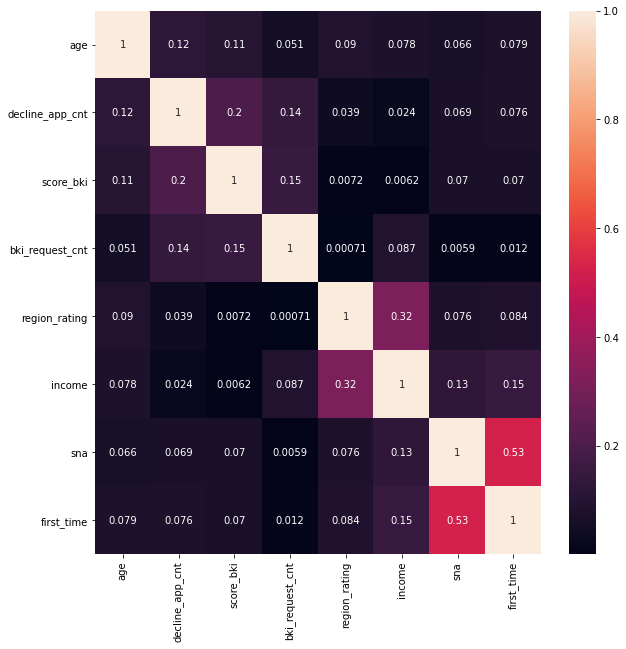

In [79]:
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'region_rating', 'income', 'sna', 'first_time'] # numerical columns
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport'] # binary columns
cat_cols = ['education', 'home_address', 'work_address'] # categories columns 
plt.rcParams['figure.figsize'] = (10,10) # size area
sns.heatmap(data[num_cols].corr().abs(),annot=True) # plot heat map correlation numerical columns

<AxesSubplot:>

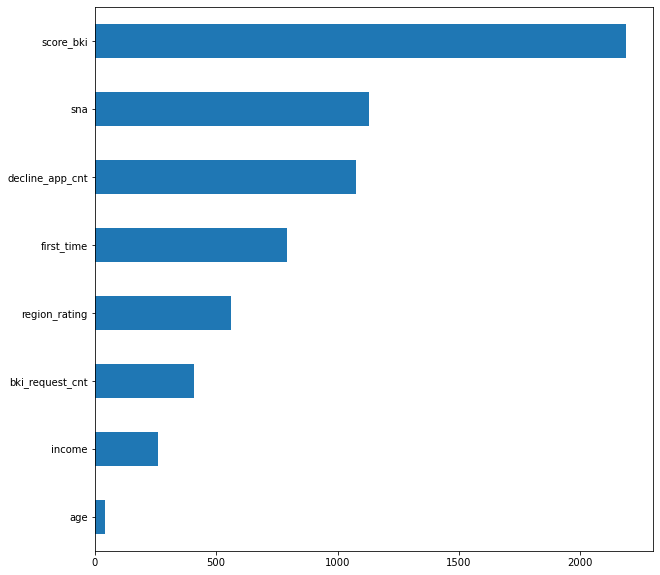

In [80]:
# creating a series of importance numeric columns from the default column
imp_num = pd.Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True) # sort values
imp_num.plot(kind = 'barh') # display plot

In [81]:
# creating a series of importance categorical and binary columns from the default column
imp_cat = pd.Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                            discrete_features = True), index = bin_cols + cat_cols)
imp_cat.sort_values()

sex                 0.000106
car                 0.000630
good_work           0.000662
car_type            0.001181
foreign_passport    0.001578
work_address        0.002271
education           0.002439
home_address        0.002808
dtype: float64

Most of all, there is a correlation between the age of availability of information about the borrower and the relationship of the borrower with the bank's clients. 

The connection between earnings and the region of residence is more logical.
However, earnings are less related to the target variable. 

The target variable is most related to credit score and home address and least of all to age and gender.

## Data preprocessing and model

(73799,) (73799, 24)
Logistic Regression ROC AUC = 0.740
ROC AUC train: 0.728
change: 0.012
ROC AUC undersampling: 0.739
1 in train: 0.500 
 1 in test: 0.124


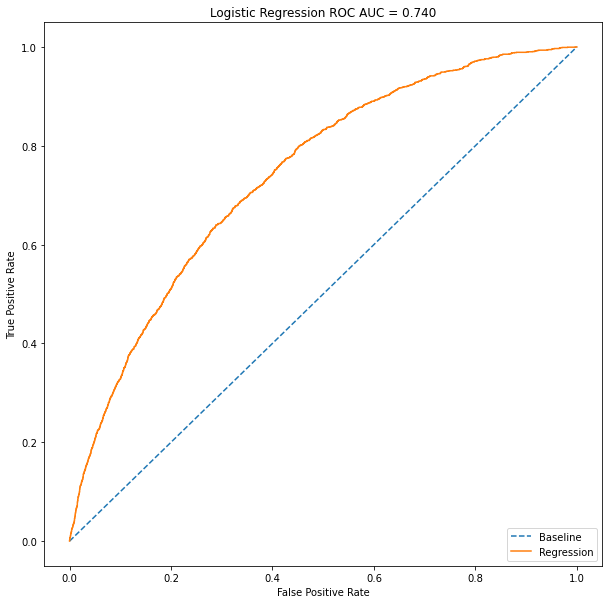

In [82]:
import warnings; warnings.simplefilter('ignore') # ignore warnings 
# dividing data into training and test samples
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.default.values # our target
# splitting categories into columns of binary values 
X_cat = OneHotEncoder(sparse = False).fit_transform(train_data[cat_cols].values)
X_num = StandardScaler().fit_transform(train_data[num_cols].values) # standardization numeric data
X = np.hstack([X_num, train_data[bin_cols].values, X_cat]) # concatenate columns
print(y.shape, X.shape) # print size 

logreg(X, y, n = 1) # plot logistic regression curve and value if undersampling 

On training data, the model shows a worse score than on test data, which means there is no retraining.

Balancing the data didn't make the score better. 

In [83]:
# removing low-dependency columns
X_num = StandardScaler().fit_transform(train_data[num_cols[-7:]].values) # standardization numeric data 
X = np.hstack([X_num, train_data[bin_cols[-4:]].values, X_cat]) # concatenate columns 

logreg(X, y) # get logistic regression metric value
print(bin_cols[-4:],num_cols[-7:]) # what columns used

Logistic Regression ROC AUC = 0.736
ROC AUC train: 0.725
change: 0.011
['car', 'car_type', 'good_work', 'foreign_passport'] ['decline_app_cnt', 'score_bki', 'bki_request_cnt', 'region_rating', 'income', 'sna', 'first_time']


Removing columns that had little effect on the target variable did not improve the score. 

## Feature engineering

array([[<AxesSubplot:title={'center':'days'}>]], dtype=object)

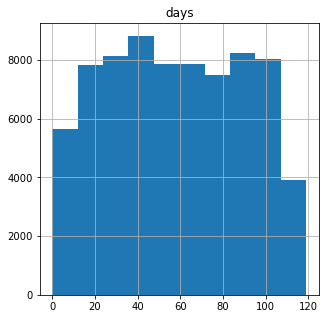

In [91]:
date_max = train_data.app_date.max() # latest date 
X = pd.DataFrame({'days':train_data.app_date.apply(lambda x:(date_max-x).days)}) # replacing dates with the number of days from the maximum date 
plt.rcParams['figure.figsize'] = (5,5) # size area
X.hist()

In [85]:
X = np.hstack([X, train_data.iloc[:, 4:5] ** 3, np.sqrt(train_data.iloc[:, 14:15])]) # concatenate columns, cube a column with age, root an income column
X = StandardScaler().fit_transform(X) # standardize data

X_cat = OneHotEncoder(sparse = False).fit_transform(train_data[cat_cols].values) # breaking categorical data into binary columns
X_num = StandardScaler().fit_transform(train_data[num_cols].values) # standardize numerical data
X = np.hstack([X, X_num, train_data[bin_cols].values, X_cat]) # concatenate data 

logreg(X, y) # get logistic regression metric value 

Logistic Regression ROC AUC = 0.743
ROC AUC train: 0.731
change: 0.012


The addition of new data improved the score slightly.

## Hyperparameters

In [86]:
penalty = ['l1', 'l2'] # add regularization types
C = np.logspace(0, 4, 10) # set constraints for the regularization parameter 
hyperparameters = dict(C=C, penalty=penalty) # create  dictionary with hyperparameters
model = LogisticRegression()
model.fit(X, y) # model training 
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0) # create a 5-fold cross-validation search grid
best_model = clf.fit(X, y) # searching best parameters
# View best hyperparameters
best_p = best_model.best_estimator_.get_params()['penalty']
best_C = best_model.best_estimator_.get_params()['C']
print('Best Penalty:', best_p) 
print('Best:', best_C) 

Best Penalty: l2
Best: 7.742636826811269


In [87]:
logreg(X, y, p = best_p, C = best_C) # get logistic regression metric value with hyperparameters 

Logistic Regression ROC AUC = 0.743
ROC AUC train: 0.731
change: 0.012


## Submission 

If everything suits, prepare Submission for kaggle

In [88]:
test_data.sample(10) #  display test data

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
7664,42572,2014-02-19,1,1,25,0,0,2,0,-1.675699,4.0,60.0,2,3,35000.0,3.0,1,0,0
3813,7795,2014-01-15,0,1,44,0,0,0,0,-2.769467,2.0,60.0,1,2,20000.0,2.0,2,0,0
21412,102628,2014-04-20,1,0,33,0,0,0,0,-1.914925,1.0,70.0,2,3,24600.0,1.0,2,0,0
13110,17241,2014-01-24,2,0,37,1,1,0,0,-1.881290,2.0,50.0,1,2,80000.0,2.0,3,0,0
13020,93696,2014-04-10,1,1,61,1,1,0,0,-2.325332,2.0,40.0,2,3,65000.0,1.0,3,0,0
4002,77495,2014-03-25,1,0,45,0,0,0,0,-2.474685,0.0,50.0,1,1,15000.0,2.0,3,0,0
6345,76010,2014-03-24,1,0,29,0,0,1,0,-1.274997,2.0,60.0,2,2,20000.0,3.5,1,0,0
30498,20069,2014-01-27,1,1,33,0,0,2,0,-2.145357,0.0,50.0,1,2,40000.0,1.0,3,0,0
20271,39576,2014-02-15,1,0,26,0,0,0,1,-1.931256,0.0,75.0,2,3,35000.0,3.5,3,0,0
13826,20278,2014-01-27,0,1,47,1,0,1,0,-1.402708,0.0,40.0,2,3,25000.0,1.0,2,0,0


In [89]:
Model = LogisticRegression(C = best_C, penalty = best_p) # set hiperparameters 
Model.fit(X,y) # model training
predict_submission = Model.predict_proba(prepro(test_data))[:,1] # data preparation and prediction

In [90]:
sample_submission = pd.DataFrame({'client_id': test_data.client_id, 'default': predict_submission}) # create data frame
sample_submission.to_csv('submission.csv', index=False) # create csv
sample_submission.head(10)

,client_id,default
0,74835,0.039234
1,17527,0.355906
2,75683,0.061578
3,26883,0.090283
4,28862,0.029175
5,99881,0.177644
6,26630,0.326236
7,79934,0.028709
8,16605,0.029633
9,105449,0.029019
